In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
# from funcions_v2 import *

In [2]:
import sys
sys.path.append('/nfs/pic.es/user/m/mgraell/Halo_ML')
from  funcions_v2 import *

# Dades

In [3]:
cat = get_dataset('/data/astro/scratch/lcabayol/EUCLID/GHalo_FS/FS2_clusters_z04.parquet',
                  ['halo_id','color_kind','x_in_halo', 'y_in_halo','z_in_halo', 'radis', 'abs_mag_r01',
                   'g01r01_hod','ax_halo', 'ay_halo', 'az_halo','b_to_a_halo','c_to_a_halo'])
len(cat)/1e6

25.077341

In [4]:
# # Llista de halos amb dades i labels
# halo_id_values = np.unique(cat['halo_id'].to_numpy())
# halo_id_values, len(halo_id_values)

# llista_tensors = []
# for halo_id in halo_id_values:
#     llista_tensors.append(torch.tensor(cat[cat['halo_id'] == halo_id].to_numpy()))

# len(llista_tensors)

# # Separo dades i labels; de labels agafo c i b to a
# X_list=[]
# y_list=[]
# print(llista_tensors[0].shape)
# for i in range(len(halo_id_values)):
#     X_list.append(llista_tensors[i][:,2:-5])
#     y_list.append(llista_tensors[i][:,-2:])
# print(len(X_list), len(y_list), X_list[0].shape, y_list[0].shape, X_list[0].dtype, y_list[0].dtype)


# # Faig que només hi hagi una label per halo, no una per galàxia.
# unique_y = []
# for i in range(len(y_list)):
#     unique_y.append(torch.unique(y_list[i]).squeeze())
cat_gb = cat.groupby('halo_id')
y_list = cat_gb.first()[['b_to_a_halo', 'c_to_a_halo']].reset_index()
X_list = cat_gb[['x_in_halo', 'y_in_halo', 'z_in_halo', 'radis', 'abs_mag_r01', 'g01r01_hod']].apply(lambda x: x.values.tolist()).reset_index(name='properties')
X_list = X_list['properties'].tolist()
unique_y = y_list[['b_to_a_halo','c_to_a_halo']].to_numpy().tolist()

In [5]:
del cat, cat_gb

In [6]:
X_list_full = X_list.copy()
unique_y_full = unique_y.copy()

In [7]:
for i in range(len(X_list)):
    if len(X_list[i]) < 400 or len(X_list[i]) >= 3000:
        X_list[i] = 'per eliminar'
        unique_y[i] = 'per eliminar'

X_list = [halo for halo in X_list if halo != 'per eliminar']
unique_y = [halo for halo in unique_y if halo != 'per eliminar']

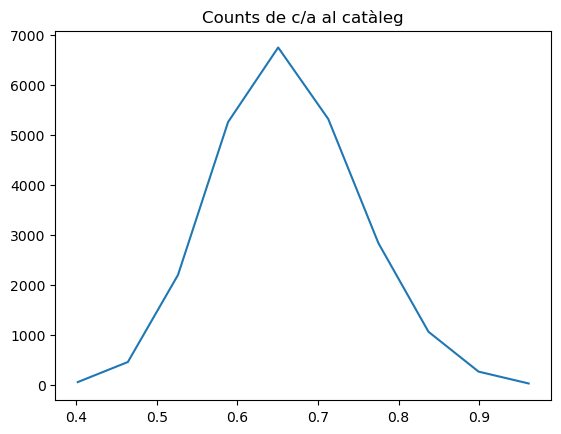

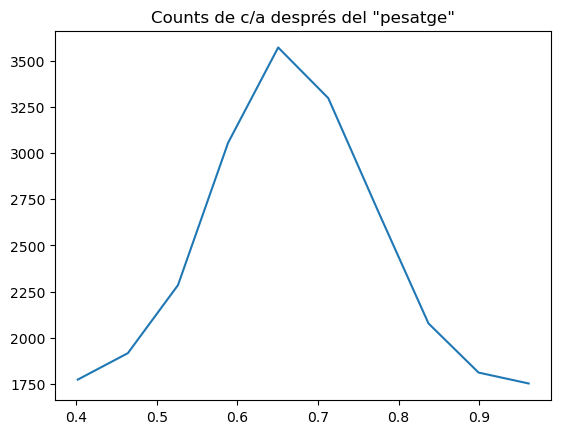

(torch.Size([24224, 2]), 24224, 45666, 24224, 45666)

In [8]:
# Aquí repeteixo els halos amb formes menys representades; els histogrames
# mostren la freqüència dels diferents b/a abans i després de fer-ho.

unique_y_tensor = torch.tensor(np.array(unique_y))


counts, bins = torch.histogram(unique_y_tensor[:,1], bins=10)
plt.plot(bins.numpy()[1:], counts.numpy())
plt.title('Counts de c/a al catàleg') 
plt.show()
moda = max(counts)

X_list_pes = X_list.copy()
unique_y_pes = list(unique_y_tensor)
for j in range(len(unique_y_tensor)):
    halo_shape = unique_y_tensor[j]
    halo_data = X_list[j]
    for i in range(len(counts)):
        if halo_shape[1] > bins[i] and halo_shape[1] < bins[i+1]:
            size= random_round(moda/(2*counts[i]) - 1/2)
            for k in range(size):
                insert_index =  np.random.randint(0,len(unique_y_pes))
                unique_y_pes.insert(insert_index, halo_shape)
                X_list_pes.insert(insert_index, halo_data)

unique_y_pes_tensor = unique_y_pes[0]
for i in range(1, len(unique_y)):
    unique_y_pes_tensor = torch.vstack((unique_y_pes_tensor, unique_y_pes[i]))


counts, bins = torch.histogram(unique_y_pes_tensor[:,1], bins=10)
plt.plot(bins.numpy()[1:], counts.numpy())
plt.title('Counts de c/a després del "pesatge"')
plt.show()
unique_y_pes_tensor.shape, len(unique_y), len(unique_y_pes), len(X_list), len(X_list_pes)

In [9]:
# Faig batches
_, X_test = make_test_train_batched(X_list)
_, y_test_list = make_test_train_batched(unique_y)

X_train, _ = make_test_train_batched(X_list_pes)
y_train_pes_list, _ = make_test_train_batched(unique_y_pes)

_, X_test_full = make_test_train_batched(X_list_full)
_, y_test_full = make_test_train_batched(unique_y_full)


/nfs/pic.es/user/m/mgraell/Halo_ML/funcions_v2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list = [torch.tensor(sample).to(torch.float32) for sample in batch]


In [10]:
del X_list, unique_y, X_list_pes, unique_y_pes, X_list_full, unique_y_full, _

In [11]:
y_test = torch.tensor(np.array(y_test_list))
y_train = torch.tensor(np.array(y_train_pes_list))


In [12]:
X_test_analitic = X_test_full.copy()
for i in range(len(X_test_analitic)):
    for j in range(len(X_test_analitic[i])):
        halo = X_test_analitic[i][j]
        X_test_analitic[i][j] = [gal for gal in halo if gal[4] != 0]
    

# Model

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
#from funcions_v2 import *
import scipy as scp

In [14]:
X_test_tot = X_test_full.copy()
y_test_tot = y_test_full.copy()

In [15]:
del X_test_full, y_test_full, y_test_list, y_train_pes_list

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
class Model(nn.Module):
    def __init__(self, input_len:int, output_len:int, batch_size:int):
        super().__init__()
                        
        self.lin_block = nn.Sequential(
                                nn.Linear(input_len, 256),
                                nn.ELU(),
                                nn.Linear(256, 256),                                
                            )
        self.lin_block2 = nn.Sequential(
                                nn.Linear(256, 256),
                                nn.ELU(),
                                nn.Linear(256, output_len),
                            )
        self.batch_size = batch_size
        self.input_len = input_len
        self.output_len = output_len



    def forward(self, data):
        x = [self.lin_block(x_elem.to(device)) for x_elem in data]
        
        # xsum =[xx.sum(dim=0) for xx in x]
        # x = torch.stack(xsum)
        
        max_len = max([len(x_elem) for x_elem in data])

        padded_x = [torch.nn.functional.pad(x_elem, (0, 0, 0, max_len - len(x_elem))) for x_elem in x]

        stacked_data = torch.stack(padded_x)

        x = stacked_data.sum(dim=1)
        
        output = self.lin_block2(x)

        return output.squeeze()

In [18]:
torch.manual_seed(42)
input_len = 6
output_len = 2
model = Model(input_len=input_len, output_len=output_len, batch_size = 128).to(device)

In [19]:
model(X_test[0]).shape, y_test.shape, len(X_test)

(torch.Size([128, 2]), torch.Size([37, 128, 2]), 37)

In [20]:
def get_loss_acc(model, X, y, loss_fn, exigencia):
    model.eval()
    test_loss = 0
    if output_len > 1:
        acc = np.zeros(output_len)
    else:
        acc = 0
    with torch.inference_mode():
        for i in range(len(X)):
            output = model(X[i]).to(device)
            labels = y[i].to(device)
            test_loss += loss_fn(output, labels)
            encerts = 0
            if output_len > 1:
                for j in range(len(output)):  
                    rel_err = torch.abs(output[j]-labels[j])*100/labels[j] 
                    for k in range(output_len):    
                        if rel_err[k] < exigencia:
                            acc[k] += 1/len(output)
            else:
                for j in range(len(output)):  
                    rel_err = torch.abs(output[j]-labels[j])*100/labels[j] 
                    if rel_err < exigencia:
                        acc += 1/len(output)                

        test_loss /= len(X)
        acc *= 100/len(X) 
        print(f'Test loss: {test_loss: .5f}, Accuracy: {np.round(acc, 2)} %')
        return test_loss, acc

def train_step(model, X, y, loss_fn, opt, scheduler, use_scheduler, epoch, print_every):
    train_loss = 0
    model.train()
    
    for i in range(len(X)):
        opt.zero_grad()
        output = model(X[i]).to(device)
        

        loss = loss_fn(output, y[i].to(device))
        loss.backward()
        opt.step()

        train_loss += loss.item()

    train_loss /= len(X)
    if epoch % print_every == 0:
        print(f'Train loss: {train_loss:.5f}')
    if use_scheduler:
        scheduler.step(loss)


def test_step(model, X, y, loss_fn, epoch, print_every, epochs, exigencia):
    if epoch % print_every == 0:
        test_loss, acc = get_loss_acc(model, X, y, loss_fn, exigencia)
        print(np.round(epoch/epochs *100, 1), '%')

In [21]:
lr = 1e-2 
mode = 'min'
factor = 0.2
patience = 300
threshold = 0.0001
threshold_mode = 'abs'

In [22]:
opt = torch.optim.Adagrad(model.parameters(), lr=lr)
loss_fn = nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode=mode, factor=factor, patience=patience, threshold=threshold, threshold_mode=threshold_mode)
save_file = 'bctoa_model_4.pt'
save_file2 = 'prova.pt'

In [ ]:
%%time
epochs = 2500
print_every = 15

for epoch in range(epochs):
    train_step(model=model, X=X_train, y=y_train, loss_fn=loss_fn, opt=opt,
                scheduler=scheduler, use_scheduler=False, epoch=epoch, print_every=print_every)
    test_step(model=model, X=X_test, y=y_test, loss_fn=loss_fn, epoch=epoch,
              print_every=print_every, epochs=epochs, exigencia=10)
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'/nfs/pic.es/user/m/mgraell/Halo_ML/{save_file}')

Train loss: 235.46906
Test loss:  7.50898, Accuracy: [0. 0.] %
0.0 %
Train loss: 0.59919
Test loss:  0.07511, Accuracy: [59.92 52.07] %
0.6 %
Train loss: 0.12845
Test loss:  0.06786, Accuracy: [62.25 56.14] %
1.2 %
Train loss: 0.08895
Test loss:  0.07416, Accuracy: [57.98 50.72] %
1.8 %
Train loss: 0.08601
Test loss:  0.07142, Accuracy: [60.37 52.74] %
2.4 %
Train loss: 0.08489
Test loss:  0.07045, Accuracy: [62.54 52.22] %
3.0 %
Train loss: 0.08209
Test loss:  0.07031, Accuracy: [65.18 50.65] %
3.6 %
Train loss: 0.08115
Test loss:  0.07274, Accuracy: [61.55 50.3 ] %
4.2 %
Train loss: 0.07916
Test loss:  0.07342, Accuracy: [61.4  49.41] %
4.8 %
Train loss: 0.07923
Test loss:  0.06824, Accuracy: [63.22 54.31] %
5.4 %
Train loss: 0.07768
Test loss:  0.06738, Accuracy: [63.56 54.56] %
6.0 %
Train loss: 0.09348
Test loss:  0.07161, Accuracy: [61.55 50.57] %
6.6 %
Train loss: 0.07625
Test loss:  0.06798, Accuracy: [63.81 53.74] %
7.2 %
Train loss: 0.07494
Test loss:  0.06788, Accuracy: [63.

In [ ]:
torch.save(model.state_dict(), f'/nfs/pic.es/user/m/mgraell/Halo_ML/{save_file}')

# Anàlisi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
import scipy as scp
from funcions_v2 import *


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

class Model(nn.Module):
    def __init__(self, input_len:int, output_len:int, batch_size:int):
        super().__init__()
                        
        self.lin_block = nn.Sequential(
                                nn.Linear(input_len, 256),
                                nn.ELU(),
                                nn.Linear(256, 256),                                
                            )
        self.lin_block2 = nn.Sequential(
                                nn.Linear(256, 256),
                                nn.ELU(),
                                nn.Linear(256, output_len),
                            )
        self.batch_size = batch_size
        self.input_len = input_len
        self.output_len = output_len



    def forward(self, data):
        x = [self.lin_block(x_elem.to(device)) for x_elem in data]
        # xsum =[xx.sum(0) for xx in x]
        # x = torch.stack(xsum)
        
        max_len = max([len(x_elem) for x_elem in data])

        padded_x = [torch.nn.functional.pad(x_elem, (0, 0, 0, max_len - len(x_elem))) for x_elem in x]

        stacked_data = torch.stack(padded_x)

        x = stacked_data.sum(dim=1)
        
        output = self.lin_block2(x)

        return output.squeeze()
    
torch.manual_seed(42)
input_len = 6
output_len = 2
model = Model(input_len=input_len, output_len=output_len, batch_size = 128).to(device)
model.load_state_dict(torch.load('/nfs/pic.es/user/m/mgraell/Halo_ML/bctoa_model_blau_0.pt'))

print(len(X_test_tot), len(X_test_analitic), y_test_tot.shape)

In [ ]:
for i in range(len(X_test_tot)):
    for j in range(len(X_test_tot[i])):
        X_test_tot[i][j] = torch.tensor(np.array(X_test_tot[i][j]))
        X_test_analitic[i][j] = torch.tensor(np.array(X_test_analitic[i][j]))

In [ ]:
model.eval()

labels_tot_list = []
preds_tot_list = []
preds_analitic_tot_list = []


nan_index0 = []
nan_index1 = []
with torch.inference_mode():
    preds_tot = np.array([model(batch).cpu().numpy() for batch in X_test_tot])
    labels_tot = y_test_tot.cpu().numpy()
    print(preds_tot.shape)
    print(labels_tot.shape)
    preds_tot = preds_tot.reshape(preds_tot.shape[0]*preds_tot.shape[1], preds_tot.shape[2])
    labels_tot = labels_tot.reshape(labels_tot.shape[0]*labels_tot.shape[1], labels_tot.shape[2])
    for i in range(len(X_test_analitic)):
        preds_analitic = []
        for j in range(len(X_test_analitic[i])):
            computeshape3d = compute_shape_3D(X_test_analitic[i][j][:,0].numpy(),X_test_analitic[i][j][:,1].numpy(),
                                              X_test_analitic[i][j][:,2].numpy(), 'standard')
            preds_analitic.append(np.array([computeshape3d[1][1]/computeshape3d[1][0], computeshape3d[1][2]/computeshape3d[1][0]]))
        preds_analitic_tot_list.append(np.array(preds_analitic))
    preds_analitic_tot = np.array(preds_analitic_tot_list)
    print(preds_analitic_tot.shape)
    preds_analitic_tot = preds_analitic_tot.reshape(preds_analitic_tot.shape[0]*preds_analitic_tot.shape[1], preds_analitic_tot.shape[2])

    print(preds_analitic_tot.shape)
    
    preds_analitic_btoa = preds_analitic_tot[:,0]
    preds_analitic_ctoa = preds_analitic_tot[:,1]

    for i in range(len(preds_analitic_btoa)):
        if np.isnan(preds_analitic_btoa[i]):
            nan_index0.append(i)
    inds_to_delete0 = sorted(nan_index0, reverse=True)
    for i in range(len(preds_analitic_ctoa)):
        if np.isnan(preds_analitic_ctoa[i]):
            nan_index1.append(i)
    inds_to_delete1 = sorted(nan_index1, reverse=True)
    
    labels_analitic_btoa = labels_tot[:,0]
    labels_analitic_ctoa = labels_tot[:,1]
    
    for i in inds_to_delete0:
        labels_analitic_btoa = np.delete(labels_analitic_btoa, i)
        preds_analitic_btoa = np.delete(preds_analitic_btoa, i)
    for i in inds_to_delete1:
        labels_analitic_ctoa = np.delete(labels_analitic_ctoa, i)
        preds_analitic_ctoa = np.delete(preds_analitic_ctoa, i)

    
    print(labels_tot.shape, preds_tot.shape, labels_analitic_btoa.shape, preds_analitic_btoa.shape)
    

    corr_btoa = np.corrcoef(labels_tot[:,0], preds_tot[:,0])[0,1]
    corr_ctoa = np.corrcoef(labels_tot[:,1], preds_tot[:,1])[0,1]
    corr_analitic_btoa = np.corrcoef(labels_analitic_btoa, preds_analitic_btoa)[0,1]
    corr_analitic_ctoa = np.corrcoef(labels_analitic_ctoa, preds_analitic_ctoa)[0,1]
    
    

    
    
    plt.plot(labels_tot[:,0], preds_tot[:,0], '.', color = 'r', markersize = .5, label='Model predictions')
    plt.plot(labels_analitic_btoa, preds_analitic_btoa, '.', color = 'g', markersize = .5, label='Analytic calculation')
    plt.title('b/a')
    plt.legend()



    print('b/a r2:', np.round(corr_btoa, 2), '|', 'c/a r2:', np.round(corr_ctoa, 2))
    print('Analytic b/a r2:', np.round(corr_analitic_btoa, 2), '|', 'Analytic c/a r2:', np.round(corr_analitic_ctoa, 2))
    plt.plot(np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]),np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]), '--', color = 'cornflowerblue')

    plt.xlim(0.3,1)
    plt.ylim(0.3,1)
    plt.show()

    plt.plot(labels_tot[:,1], preds_tot[:,1], '.', color = 'r', markersize = .5, label='Model predictions')
    plt.plot(labels_analitic_ctoa, preds_analitic_ctoa, '.', color = 'g', markersize = .5, label='Analytic calculation')
    plt.title('c/a')
    plt.legend()


print('b/a r2:', np.round(corr_btoa, 2), '|', 'c/a r2:', np.round(corr_ctoa, 2))
print('Analytic b/a r2:', np.round(corr_analitic_btoa, 2), '|', 'Analytic c/a r2:', np.round(corr_analitic_ctoa, 2))
plt.plot(np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]),np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]), '--', color = 'cornflowerblue')

plt.xlim(0.3,1)
plt.ylim(0.3,1)
plt.show()




bins_number = 20


binstat = scp.stats.binned_statistic(labels_tot[:,0], preds_tot[:,0], statistic='mean', bins=bins_number, range=None)
preds_bins = binstat[0]
labels_bins = binstat[1]
labels_bins = np.delete(labels_bins, 0)

binstat_analitic = scp.stats.binned_statistic(labels_analitic_btoa, preds_analitic_btoa, statistic='mean', bins=bins_number, range=None)
preds_analitic_bins = binstat_analitic[0]

plt.plot(labels_bins, preds_bins, '-', color = 'r', label='Model predictions')
plt.plot(labels_bins, preds_analitic_bins, '-', color = 'g', label='Analytic calculation')
plt.title('b/a, binned')
plt.legend()

plt.plot([0.3,1],[0.3,1], '--', color = 'cornflowerblue')
plt.show()

binstat = scp.stats.binned_statistic(labels_tot[:,1], preds_tot[:,1], statistic='mean', bins=bins_number, range=None)
preds_bins = binstat[0]
labels_bins = binstat[1]
labels_bins = np.delete(labels_bins, 0)

binstat_analitic = scp.stats.binned_statistic(labels_analitic_ctoa, preds_analitic_ctoa, statistic='mean', bins=bins_number, range=None)
preds_analitic_bins = binstat_analitic[0]

plt.plot(labels_bins, preds_bins, '-', color = 'r', label='Model predictions')
plt.plot(labels_bins, preds_analitic_bins, '-', color = 'g', label='Analytic calculation')
plt.title('c/a, binned')
plt.legend()

plt.plot([0.3,1],[0.3,1], '--', color = 'cornflowerblue', linewidth = '1')
plt.show()


